In [1]:
# Add module path for demo.
# Todo: make wheel file -> setup file -> pip install tsx-**.whl
import os
import sys
import pyts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from tsx.perturbation import ASyncTimeSlicer
from tsx.xai.lime import LIMETimeSeries

from data_util import *
from viz import *


In [3]:
# Prepare Data Set
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"

df = load_data_set_bejin()
x_scaler, y_scaler = get_xy_scalers(df, independents, dependent)

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)

In [4]:
# Normalize data 
df_norm = df.copy()
df_norm[independents] = x_scaler.transform(df[independents].values)
df_norm[dependent] = y_scaler.transform(df[dependent].values.reshape(-1, 1))
_df = df_norm.loc[:, df_norm.columns != 'wind_direction']
# plt_x_instance(_df)

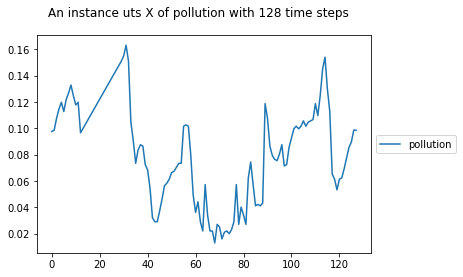

In [5]:
# uts - x
x = get_instance_x(df_norm, n_steps, ['pollution'])
x_uts = x.loc[:, x.columns != 'wind_direction']
title = f"An instance uts X of pollution with {n_steps} time steps"

plt_x_instance(x_uts, title)

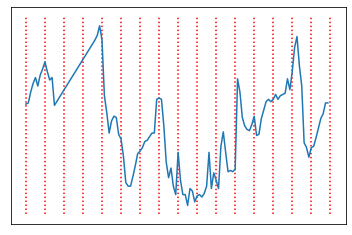

In [11]:
# uts - x-segmented
title = f"A segmented X with window size={window_size}"
plt_x_segmented(x_uts, 
    window_size, 
    title=None, 
    label_pos=-0.09)

fig = plt.gcf()
plt_hide_ticks(fig)
plt_hide_text(fig)
plt_hide_legend(fig)

In [12]:
# Perturbation Async
samples_size = 10
x_uts = x.values.T # (n_features, n_steps) 
t = ASyncTimeSlicer(window_size=window_size, off_p=0.5)
uts_sample = list(t.perturb(x_uts, n_samples=samples_size))

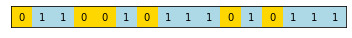

In [24]:
# Visualization Perturbation - Async and z_prime
idx = np.random.randint(0, samples_size - 1)
z_prime, _, _, = uts_sample[idx]

plt_sample_z_prime(z_prime.reshape(1, -1), ylabels=['z-prime'])

fig = plt.gcf()
plt_hide_ticks(fig)
plt_hide_subplot_xlabel(fig)
plt_hide_legend(fig)

In [25]:
# Same z_prime for different perturbation methods (replace fn)
repl_fn = ["zeros", "local_mean", "global_mean"]
z_uts = [t.to_original(x_uts, z_prime, repl_fn=fn) for fn in repl_fn]

n_segments = len(z_prime)
if np.ndim(z_prime) == 2:
    n_features, n_segments = z_prime.shape

z = np.stack(z_uts).reshape(len(repl_fn), n_steps)
z_df = pd.DataFrame(z.T, columns=repl_fn)


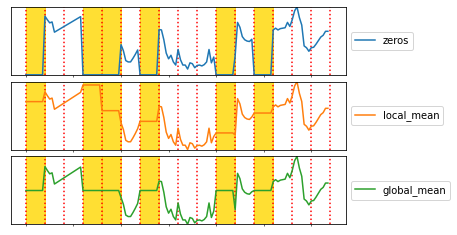

In [28]:
# Plot different perturbations with same z-prime
_zp = np.broadcast_to(z_prime, (len(repl_fn), n_segments))
plt_sample_z(z_df, z, _zp, repl_fn, window_size,
 # title="Segment Based Perturbation Methods \n for Univariate Time Series",
 label_pos=-0.1
 )

fig = plt.gcf()
plt_hide_ticks(fig)
plt_hide_subplot_xlabel(fig)
plt_hide_text(fig)

# Segment- vs Reference-set Based Perturbation


In [12]:
# Reference Set - Local Mean Replacement
size = 3
ts_set = [get_instance_x(df_norm, n_steps, ['pollution']) for i in range(size)]

ts_set_df = pd.concat(ts_set, axis=1)
cols = [f"ts-{i}" for i in range(size)]
ts_set_df.columns = cols
ts_set_df[f"local mean per reference set \n {cols}"] = ts_set_df.mean(axis=1)

In [13]:
# Segment Based - Local Mean Replacement
t = ASyncTimeSlicer(window_size=window_size, off_p=0.5)
r = t._x_replacements(x_uts, fn='local_mean')
ts_set_df["local mean per segment"] = r.ravel()

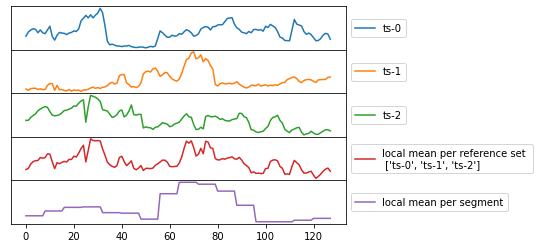

In [14]:
ts_set_df.plot(subplots=True)
fig = plt.gcf()
plt_legend(fig, per_subplot=True)
plt_hide_yticks(fig)
plt.subplots_adjust(hspace=0.0)